In [ ]:
!pip install cvxpy==1.1.17

In [ ]:
import cvxpy as cp
import numpy as np
import scipy as scipy
from scipy.sparse import random
from scipy.linalg import toeplitz
from numpy import linalg as la
from scipy.linalg import sqrtm
from numpy.ma.core import size

def GLASSO_chain(n,N,alpha,t): #define the GLASSO+SR estimator
  trials =np.arange(1,t)
  Dd = []
  Sc = []
  Vv = []
  Ss = []
  Er = []
  count = 0
  B_hat = np.matrix(np.zeros(n))
  #Create adjacency matrix for chain graph (B)
  v = np.zeros(n)
  for i in range(n):
    if i <= 1:
      v[i] = 1
    else:
      v[i] = 0
  B = toeplitz(v,v) + 2*np.matrix(np.eye(n)) #weighting the diagonals to ensure positive definiteness
  
  for i in range(len(trials)):        #computing the problem parameters for every trial 
    Binv = np.linalg.inv(B)
    Theta_X = np.matrix(np.eye(n))
    Theta_Y = Binv*Binv
    Sigma_X = np.linalg.inv(Theta_X)
    Sigma_Y = np.linalg.inv(Theta_Y)
    y_sample = scipy.linalg.sqrtm(Sigma_Y) * np.matrix(np.random.randn(n, N))
    S = np.cov(y_sample)    #Constructing the sample covariance matrix
    Sc.append(S)
    
  for i in range(len(trials)):
    Theta_hat = cp.Variable(shape=(n,n), PSD = True)
    obj = cp.Minimize(-cp.log_det(Theta_hat) + cp.trace(Sc[i]@Theta_hat) + alpha*cp.sum(cp.abs(Theta_hat)))         #Set-up the convex optimization problem
    prob = cp.Problem(obj)
    prob.solve()
    if prob.status != cp.OPTIMAL:
      raise Exception('CVXPY Error')
    Theta_hat = Theta_hat.value
    B_hat = scipy.linalg.sqrtm(Theta_hat)
    B_hat[abs(B_hat) <= 1e-2] = 0
    Error = np.linalg.norm(B_hat - B,1)
    Ss.append(B_hat)
    Er += [Error]
    print('Completed optimization parameterized by alpha = {}, obj value = {}, Inf norm = {} '.format(alpha, obj.value,Error))
    B_opt = np.where(B_hat!=0,1,0)
    B = np.where(B!=0,1,0)
    if np.array_equal(B_opt,B) == True:
      count+=1
  return count

def QGLASSO_chain(n,N,alpha,t):  #define our Maximum likelihood estimator
  trials =np.arange(1,t)
  Dd = []
  Sc = []
  Vv = []
  Ss = []
  Er = []
  count = 0
  #Create adjacency matrix for chain graph (B)
  v = np.zeros(n)
  for i in range(n):
    if i <= 1:
      v[i] = 1
    else:
      v[i] = 0
  B = toeplitz(v,v) + 2*np.matrix(np.eye(n))  #weighting the diagonals to ensure positive definiteness
  
  for i in range(len(trials)):                #computing the problem parameters for every trial
    Binv = np.linalg.inv(B)
    Theta_X = np.matrix(np.eye(n))
    Theta_Y = Binv*Binv
    Sigma_X = np.linalg.inv(Theta_X)
    Sigma_Y = np.linalg.inv(Theta_Y)
    y_sample = scipy.linalg.sqrtm(Sigma_Y) * np.matrix(np.random.randn(n, N))
    S = np.cov(y_sample)                      #Constructing the sample covariance matrix
    Sc.append(S)
  for i in range(len(trials)):
    evalue,evec = la.eigh(Sc[i])
    Lambda = np.diag(evalue)
    R = scipy.linalg.sqrtm(Lambda)
    V = evec@R
    Vv.append(V)
  for i in range(len(trials)):
    B_hat = cp.Variable(shape=(n,n), PSD=True)
    obj = cp.Minimize(-2*cp.log_det(B_hat) +  (cp.norm(B_hat@Vv[i], "fro"))**2 + alpha*cp.sum(cp.abs(B_hat)))         #Set-up the convex optimization problem
    prob = cp.Problem(obj)
    prob.solve()
    if prob.status != cp.OPTIMAL:
          raise Exception('CVXPY Error')
    B_hat = B_hat.value
    B_hat[abs(B_hat) <= 1e-1] = 0
    Error = np.linalg.norm( B_hat - B,1)
        # Store this S in the list of results for later plotting.
    Ss.append(B_hat)
    Er += [Error]
    print('Completed optimization parameterized by alpha = {}, obj value = {}, Inf norm = {} '.format(alpha, obj.value,Error))
    B_opt = np.where(B_hat!=0,1,0)
    B = np.where(B!=0,1,0)
    if np.array_equal(B_opt,B) == True:            
      count+=1
  return count                  # computing the number of times exact sparsity structure is recovered



In [ ]:
probsuccess_32 = []                                 #Initiliazing the probability of success for ML estimator for chain graphs with 32 nodes
samples_32 = np.arange(200,1001,150)
for samples in samples_32:
  success = QGLASSO_chain(32,samples,0.1,101)       # Running ML estimator on 32 node chain graph for 100 trials
  probsuccess_32.append(success)
probsuccess_32 = np.array(probsuccess_32)
probsuccess_32 = probsuccess_32/100

In [ ]:
prob_gsuccess_32 = []                                #Initiliazing the probability of success for GLASSO+SR for chain graphs with 32 nodes
samples_32 = np.arange(200,1001,150)
for samples in samples_32:
  success = GLASSO_chain(32,samples,1,101)           # Running GLASSO+SR estimator on 32 node chain graph for 100 trials
  prob_gsuccess_32.append(success)
prob_gsuccess_32 = np.array(prob_gsuccess_32)
prob_gsuccess_32 = prob_gsuccess_32/100

In [ ]:
probsuccess_64 = []                                    #Initiliazing the probability of success for ML estimator for chain graphs with 64 nodes
samples_64 = np.arange(200,1001,150)
for samples in samples_64:
  success = QGLASSO_chain(64,samples,0.1,101)        # Running ML estimator on 64 node chain graph for 100 trials
  probsuccess_64.append(success)
probsuccess_64 = np.array(probsuccess_64)
probsuccess_64 = probsuccess_64/100

In [ ]:
prob_gsuccess_64 = []                                  #Initiliazing the probability of success for GLASSO+SR estimator for chain graphs with 64 nodes
samples_64 = np.arange(200,1001,150)
for samples in samples_64:
  success = GLASSO_chain(64,samples,1,101)             # Running GLASSO+SR on 64 node chain graph for 100 trials
  prob_gsuccess_64.append(success)
prob_gsuccess_64 = np.array(prob_gsuccess_64)
prob_gsuccess_64 = prob_gsuccess_64/100

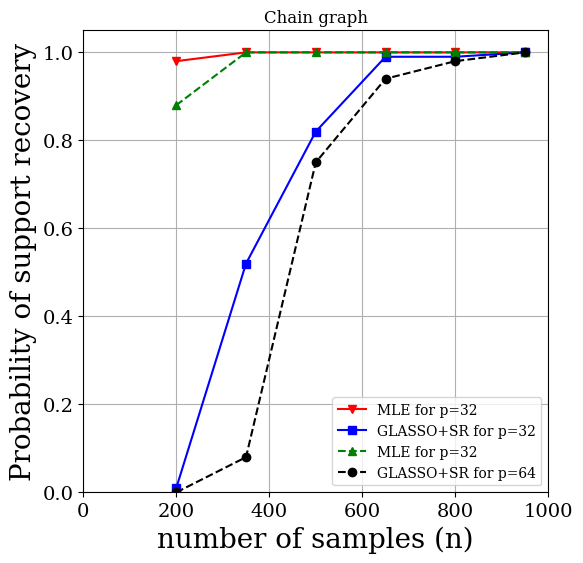

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mt
from google.colab import files 
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig = plt.figure()
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
fig.set_size_inches(6, 6)
plt.rc('axes', labelsize=20)
plt.rc('figure', titlesize=14.5)
plt.plot(samples_64,probsuccess_32,'-rv', label = 'MLE for p=32')
plt.plot(samples_64,prob_gsuccess_32,'-bs',label = 'GLASSO+SR for p=32')
plt.plot(samples_64,probsuccess_64,'--g^',label = 'MLE for p=32')
plt.plot(samples_64,prob_gsuccess_64,'--ok',label = 'GLASSO+SR for p=64')
plt.xlabel(r'number of samples (n)')
plt.ylabel('Probability of support recovery')
plt.title('Chain graph')
plt.xlim(0, 1000)
plt.ylim(0)
plt.grid(True)
plt.legend()
plt.savefig("chain_64compare.pdf", bbox_inches='tight')
plt.show()
files.download("chain_64compare.pdf")
plt.show()